In [1]:
# MODEL COMPARISON!

In [5]:
# MODEL COMPARISON

env = 'colab'  # 'colab' only
assert env == 'colab'

git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/CLAHE_AlexNet/'
final_models_path = '/content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/SuccessfulTrialsNoCLAHE/'

In [6]:
names = [
         # Names of final, fully-fit models for comparison
         'CNN',
         'Dropout',
         'AlexNet',
         'VGG16',
         'VGG19'
]

# Packages & functions

In [7]:
# %%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
            'DataProperties.py',
            'Utils.py',
            'ModelUtils.py'
    ]

Mounted at /content/drive


In [8]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [9]:
from os.path import isdir
from os.path import isfile
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import importlib


In [10]:
import Utils
import DataProperties
import ModelUtils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        Utils
    ]
)

from Utils import *

# Download necessary data

In [11]:
assert isdir(final_models_path) == True
available_models = listdir(final_models_path)

for name in names:
    assert name in available_models

In [12]:
def load_train_times(model_names, base_dir):
    res = {name: None for name in model_names}
    
    for name in model_names:
        model_dir = f'{base_dir}{name}/'
        assert(isdir(model_dir))

        file_path = f'{model_dir}training_time.csv'
        res[name] = pd.read_csv(file_path)

    return res

train_time_dict = load_train_times(names, base_dir = final_models_path)

In [13]:
def load_test_metrics(model_names, base_dir):
    
    res = {name: None for name in model_names}
    for name in model_names:
        model_dir = f'{base_dir}{name}/'
        assert isdir(model_dir)

        file_path = f'{model_dir}test_metrics_res.csv'
        res[name] = pd.read_csv(file_path)
    return res

test_metrics_dict = load_test_metrics(
    model_names = names,
    base_dir = final_models_path
)

In [14]:
def load_histories(model_names, base_dir):
    res = {name: None for name in model_names}

    for name in names:
        history_dir = f'{base_dir}{name}/Histories/'
        assert isdir(history_dir) == True

        file_path = f'{history_dir}{name}_history.csv'
        assert isfile(file_path)

        res[name] = pd.read_csv(file_path)
    
    return res


histories_dict = load_histories(
    model_names = names,
    base_dir = final_models_path
)

# Summary of learning curves

In [24]:
def plot_learning_curves(
    names, 
    hist_dict, 
    metrics_name, 
    figsize = (10, 10),
    title = 'PUT TITLE',
    ylabel = 'PUT LABEL',
    plot_validation = False
):

    fig, ax = plt.subplots(figsize = figsize)

    plt_params_dict = dict(
        linestyle = '--',
        marker = 'o',
        markersize = 8,
        markerfacecolor = 'white',
        linewidth = 2.5
    )

    fontsize = 20  # Axis writing
    ticksize = 20  # Ticks writing
    legendsize = 19

    for name in names:
        data = hist_dict[name][metrics_name]
        ax.plot(data, **plt_params_dict)
        
        if plot_validation:
            val_data = hist_dict[name][f'val_{metrics_name}']
            ax.plot(val_data, **plt_params_dict)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)
    ax.set_xlabel('Epoch', fontsize = fontsize)
    ax.set_ylabel(ylabel, fontsize = fontsize)
    ax.grid()

    
    legend_names = []
    if plot_validation:
        pairs = [[name, f'{name} (val)'] for name in names]
        for p in pairs:
            legend_names.append(p[0])
            legend_names.append(p[1])
            
    else:
        legend_names = names
    ax.legend(legend_names, fontsize = legendsize)

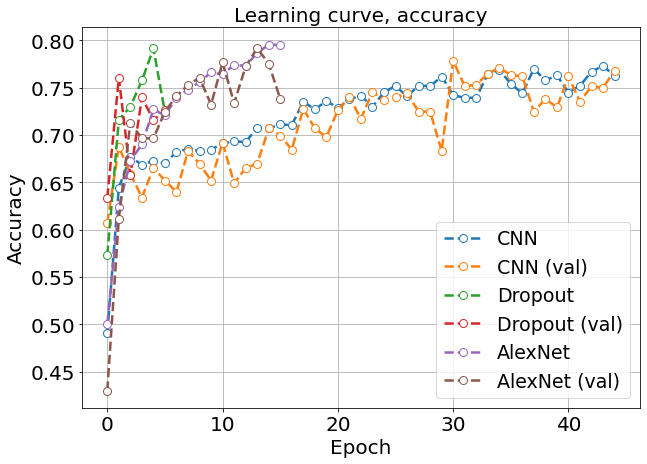

In [25]:
plot_learning_curves(
    names[:3],
    histories_dict,
    figsize = (10, 7),
    metrics_name = 'acc',
    title = 'Learning curve, accuracy',
    ylabel = 'Accuracy',
    plot_validation = True
)

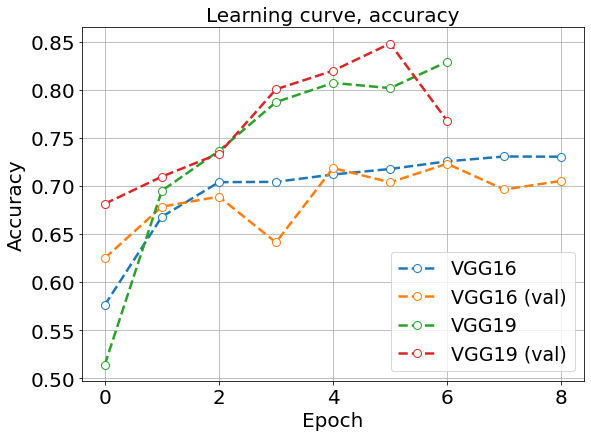

In [28]:
plot_learning_curves(
    names[3:],
    histories_dict,
    figsize = (9, 6.5),
    metrics_name = 'acc',
    title = 'Learning curve, accuracy',
    ylabel = 'Accuracy',
    plot_validation = True
)

# Collect summarized metrics

In [29]:
def summarize_metrics(model_names, metrics_dict):
    available_names = list(metrics_dict.keys())
    
    for n in model_names:
        assert n in available_names

    series = [metrics_dict[name] for name in model_names]
    res = pd.concat(series, ignore_index = True)
    res = res.set_index('Unnamed: 0')
    return res

df_summary = summarize_metrics(
    model_names = names,
    metrics_dict = test_metrics_dict
)

df_summary.head()

,F1,data_eval_time_sec,data_size,precision,recall,test_accuracy,test_loss^(-1),tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
Unnamed: 0,,,,,,,,,,,
CNN,0.825702,323.020724,681.0,0.839124,0.829662,0.829662,0.771877,10788643.0,1.0,1.0,1.0
Dropout,0.775021,142.668023,681.0,0.820184,0.775330,0.775330,0.539591,12001059.0,1.0,1.0,1.0
AlexNet,0.877747,323.070328,681.0,0.881692,0.876652,0.876652,0.393449,62381347.0,1.0,1.0,1.0
VGG16,0.829111,442.816964,681.0,0.852415,0.831131,0.831131,0.473869,134272835.0,1.0,1.0,1.0
VGG19,0.870579,502.980399,681.0,0.877432,0.870778,0.870778,0.317239,139582531.0,1.0,1.0,1.0


# Performance metrics

In [30]:
performance_metrics = [
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall'
]

In [31]:
complexity_metrics = [
                   'tr_params',
                   'data_eval_time_sec',
                   'test_loss^(-1)'
]

In [32]:
def plot_metrics(df, metric_names, model_names, figsize = (15, 15), title = ''):

    fontsize = 20
    ticksize = 20
    legendsize = 16
    tick_freq = 0.1
    
    ax = df.loc[model_names, metric_names].plot.bar(
        rot = 0,
        width = 0.9,
        figsize = figsize
    )

    y_ticks = np.arange(0, 1.01, tick_freq)
    ax.set_yticks(y_ticks)


    ax.set_xlabel('', fontsize = fontsize)
    ax.set_ylabel('Metrics', fontsize = fontsize)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)

    ax.legend(bbox_to_anchor = (1.0, 1.01), fontsize = legendsize)
    ax.grid()

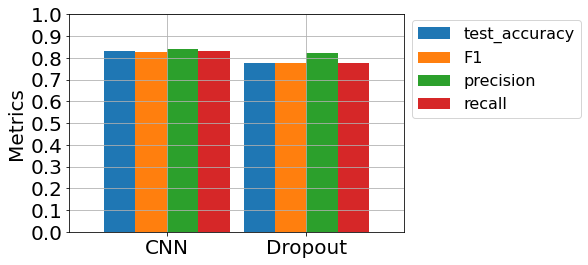

In [33]:
plot_metrics(
    df_summary, 
    performance_metrics,
    ['CNN', 'Dropout'],
    figsize = (6, 4),
    title = ''
)

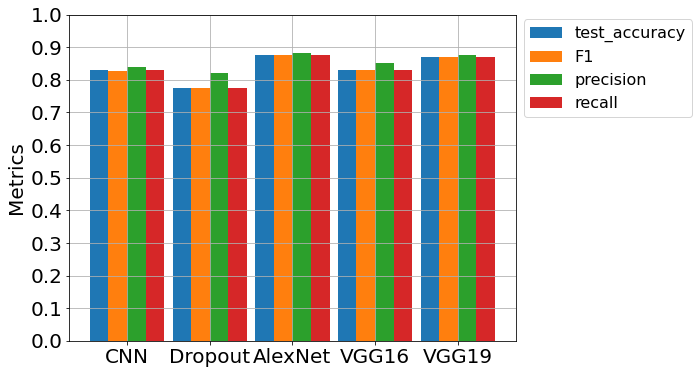

In [34]:
plot_metrics(
    df_summary, 
    performance_metrics,
    names,
    figsize = (8, 6),
    title = ''
)

# Complexity metrics

In [105]:
def plot_complexity_metrics(
    df,
    metric_names,
    model_names,
    figsize = (20, 20),
    title = ''
):

    # The complexity metrics are of different ranges 
    # and nature (time, number of parameters). We do max-normalization

    fontsize = 24
    ticksize = 22
    legendsize = 17
    tick_freq = 0.1

    df_subset = df.loc[model_names, metric_names]

    for m in metric_names:
        df_subset[m] = df_subset[m] / df_subset[m].max()  # Normalization
    
    ax = df_subset.plot.bar(
        rot = 0,
        width = 0.8,
        figsize = figsize
    )

    y_ticks = np.arange(0, 1.01, tick_freq)
    ax.set_yticks(y_ticks)


    ax.set_xlabel('', fontsize = fontsize)
    ax.set_ylabel('Complexity metrics', fontsize = fontsize)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)

    ax.legend(bbox_to_anchor = (0.7, 0.02), fontsize = legendsize, loc = 'lower center')
    ax.grid()

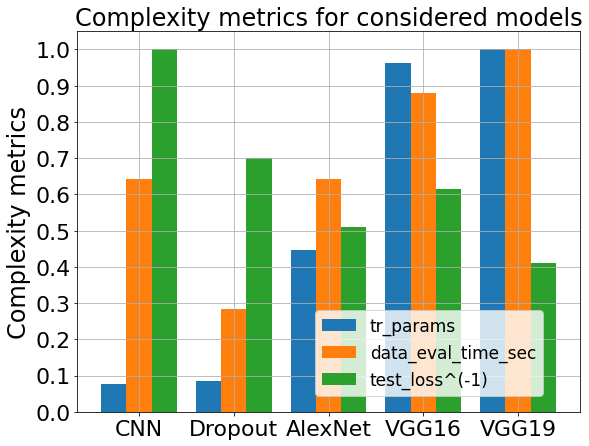

In [106]:
plot_complexity_metrics(
    df_summary, 
    complexity_metrics,
    names,
    figsize = (9, 7),
    title = 'Complexity metrics for considered models'
)

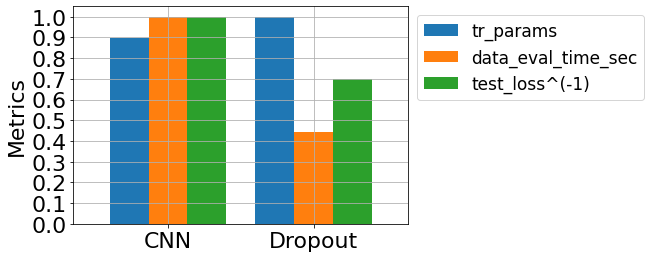

In [50]:
plot_complexity_metrics(
    df_summary, 
    complexity_metrics,
    ['CNN', 'Dropout'],
    figsize = (6, 4)
)

# Time per epoch

In [125]:
def visualize_time_per_epoch(
    train_times_dict, 
    model_names, 
    figsize = (8, 5),
    title = ''
):
    available_models = train_times_dict.keys()
    
    fig, ax = plt.subplots(figsize = figsize)
    legend_names = []

    plt_params_dict = dict(
        linestyle = '--',
        marker = 'o',
        markersize = 11,
        markerfacecolor = 'white',
        linewidth = 3
    )

    fontsize = 23
    legendsize = 17
    ticksize = 20
    tick_freq = 1
    x_lim = 15

    for model_name in model_names:
        assert model_name in available_models

        time_df = train_times_dict[model_name]
        assert model_name in time_df.columns
        
        time_data = train_times_dict[model_name][model_name].values
        time_data = time_data[time_data != ''][0]

        deltas = [
                  time_data[i] - time_data[i - 1] for i in range(1, len(time_data))
        ]
        deltas.insert(0, time_data[0])
        ax.plot(deltas, **plt_params_dict)

        legend_names.append(model_name)

    ax.grid()
    ax.legend(legend_names, fontsize = legendsize)
    
    ax.set_xlim((0, 15))
    ax.set_title(title, fontsize = fontsize)
    ax.set_xlabel('Epoch', fontsize = fontsize)
    ax.set_ylabel('Time per epoch, sec', fontsize = fontsize)
    ax.tick_params(axis = 'both', labelsize = ticksize)
    
    x_ticks = np.arange(0, x_lim, tick_freq)
    ax.set_xticks(x_ticks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


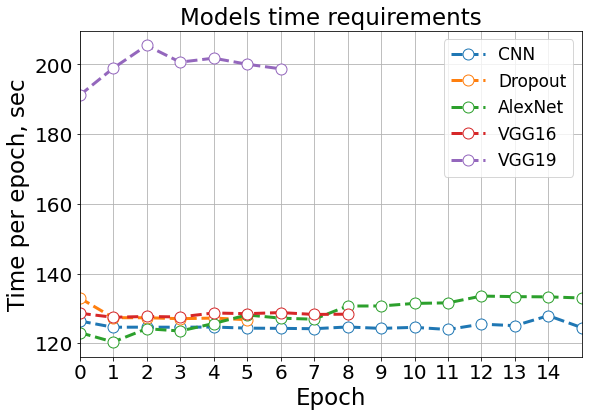

In [126]:
visualize_time_per_epoch(
    train_times_dict = train_time_dict,
    model_names = names,
    figsize = (9, 6),
    title = 'Models time requirements'
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


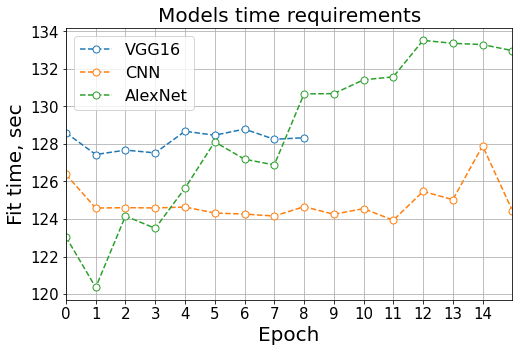

In [111]:
visualize_time_per_epoch(
    train_times_dict = train_time_dict,
    model_names = ['VGG16', 'CNN', 'AlexNet'],
    figsize = (8, 5),
    title = 'Models time requirements'
)

# Full learning time

In [131]:
def plot_overall_learning_times(
    train_times_dict, 
    model_names,
    figsize = (8, 6),
    title = 'SET TITLE'
):
    available_models = train_times_dict.keys()
    
    fig, ax = plt.subplots(figsize = figsize)
    legend_names = []

    plt_params_dict = dict(
        linestyle = '--',
        marker = 'o',
        markersize = 11,
        markerfacecolor = 'white',
        linewidth = 3
    )

    fontsize = 23
    legendsize = 17
    ticksize = 20
    tick_freq = 1
    x_lim = 15

    final_times = {}
    for model_name in model_names:
        assert model_name in available_models

        time_df = train_times_dict[model_name]
        assert model_name in time_df.columns
        

        full_train_time = train_times_dict[model_name][model_name].values[-1][0
        tinal_times[model_name] = full_train_time

    ax.barplot(final_times, **plt_params_dict)

    ax.grid()
    ax.legend(model_names, fontsize = legendsize)
    
    ax.set_xlim((0, 15))
    ax.set_title(title, fontsize = fontsize)
    ax.set_xlabel('Epoch', fontsize = fontsize)
    ax.set_ylabel('Time per epoch, sec', fontsize = fontsize)
    ax.tick_params(axis = 'both', labelsize = ticksize)
    
    x_ticks = np.arange(0, x_lim, tick_freq)
    ax.set_xticks(x_ticks)



IndexError: ignored

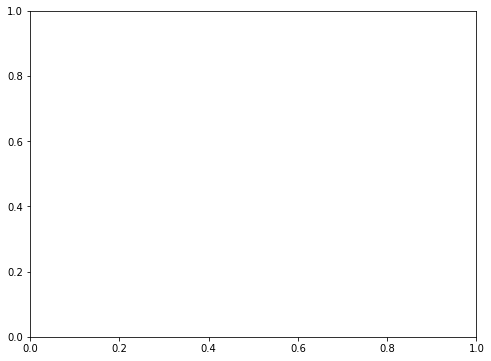

In [132]:
plot_overall_learning_times(
    train_time_dict, 
    ['CNN', 'Dropout'],
    figsize = (8, 6),
    title = 'SET TITLE'
)

# Domain - related metrics

# Confusion matrices

In [ ]:
for m_name, model in models.items():
    test_flow.reset()
    plot_confusion_matrix(
        Y_true = test_flow.classes, 
        Y_pred = model.flow_predict(
            test_flow,
            test_steps
        ),
        class_indices = test_flow.class_indices
    )

# Layers interpretation

In [ ]:
img_n = 7

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 0, 
        n_kernel = 0, 
        
        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],  # 10th image 
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 4,
        n_kernel = 0,

        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )